In [33]:
from __future__ import division
#======================= Importing libraries and Data ===========================
#
%matplotlib inline


import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
config.allow_soft_placement = False
CUDA_VISIBLE_DEVICES = 1
sess = tf.InteractiveSession(config=config)

import numpy as np
from scipy.misc import imsave
from scipy.misc import imresize
from sklearn.cluster import KMeans
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import seaborn
import math
import matplotlib.gridspec as gridspec
import os
import pylab
import time

from matplotlib import rcParams

# from tensorflow.examples.tutorials.mnist import input_data
# mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
########################################################################
#                    drawing progressbar in console
########################################################################

#import libraries
import progressbar as pb

#define progress timer class
class progress_timer:

    def __init__(self, n_iter, description="Something"):
        self.n_iter         = n_iter
        self.iter           = 0
        self.description    = description + ': '
        self.timer          = None
        self.initialize()

    def initialize(self):
        #initialize timer
        widgets = [self.description, pb.Percentage(), ' ',   
                   pb.Bar(marker=pb.RotatingMarker()), ' ', pb.ETA()]
        self.timer = pb.ProgressBar(widgets=widgets, maxval=self.n_iter).start()

    def update(self, q=1):
        #update timer
        self.timer.update(self.iter)
        self.iter += q

    def finish(self):
        #end timer
        self.timer.finish()
        
# #initialize
# pt = progress_timer(description= 'For loop example', n_iter=10000000)  
# #for loop example
# for i in range(0,10000000):  
#     #update
#     pt.update()
# #finish
# pt.finish()  


# Generating lin_sep

def lin_sample_generator(N_points, k, b, margin=0.3): 
    labels = []
    x = np.linspace(-1, 1)
    def linear_func(x_, k_ = k, b_ = b):
        return k_*x_ + b_
    y = linear_func(x, k, b)
    points = []
    i = 0

    while i <= N_points:
        x_p = np.random.uniform(-1,1, 1)[0]
        y_p = np.random.uniform(-1.5,1.5, 1)[0]
        p1 = np.array([x[0], y[0]])
        p2 = np.array([x[10], y[10]])
        p3 = np.array([x_p, y_p])
        d = np.linalg.norm(np.cross(p2-p1, p1-p3))/np.linalg.norm(p2-p1)
        points.append(np.array([x_p, y_p]))
        if y_p > linear_func(x_p):
            l_p = 1
        else:
            l_p = 0
        lab = np.zeros(2)
        lab[l_p] = 1
        if d < margin/2:
            flipping = np.random.randn()
            if flipping > 0:
                for k in range(len(lab)):
                    lab[k] = 1 - lab[k]

        labels.append(lab)
        i += 1
        
    return np.array(points), np.array(labels)
            
def drawing_scatter(points, labels, k, b):
    x = np.linspace(-1, 1)
    def linear_func(x_, k_ = k, b_ = b):
        return k_*x_ + b_
    y = linear_func(x, k, b)
    plt.plot(x,y)
    plt.xlim(-1,1)
    plt.ylim(-1.5, 1.5)
    colors = []
    colors_variety=["#0000FF", "#55A868"]
    for label in labels:
        l_p = list(label).index(1)
        colors.append(colors_variety[l_p])
    plt.scatter(np.array(points).T[0], np.array(points).T[1], color = colors)

def drawing_classification(points, labels, k, b, W):
    x = np.linspace(-1, 1, 1000)

    plt.xlim(-1,1)
    plt.ylim(-1.5, 1.5)
    colors = []
    colors_variety=["#0000FF", "#55A868"]
    for label in labels:
        l_p = list(label).index(1)
        colors.append(colors_variety[l_p])
    plt.scatter(np.array(points).T[0], np.array(points).T[1], color = colors)
    y = np.polynomial.polynomial.polyval(x,W)
    plt.plot(x,y[0])
    plt.plot(x, k*x, '--')

/home/dmerkulov/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


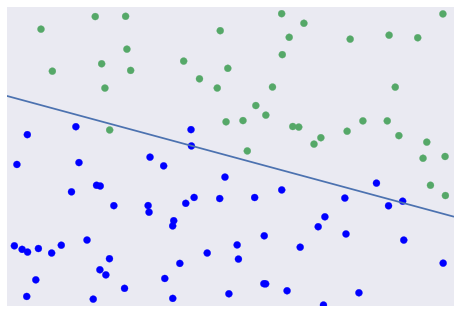

In [27]:
# X,y +train, +test sample generation
#=================== Data Preparation ================================
k = np.random.randn()
b = 0
X_train, y_train = lin_sample_generator(100, k, b)
X_test, y_test = lin_sample_generator(30, k, b)

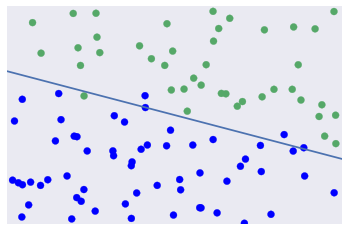

In [53]:
# Train drawing
plt.xticks([], [])
plt.yticks([], [])
drawing_scatter(X_train, y_train, k, b)
# plt.savefig('line.pdf')

Polynomial madness: 100% |||||||||||||||||||||||||||||||||||||||| Time: 0:04:20


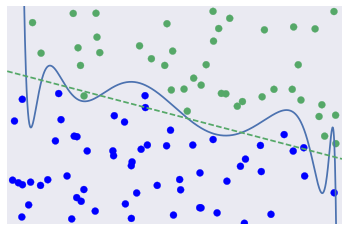

In [54]:
#====================== Polynom overfitting =======================
#======================= Model definition ==========================
N = 50 #degree of polynomial fitting

x = tf.placeholder(tf.float32, shape = (None, 2))
y_ = tf.placeholder(tf.float32, shape=(None, 2)) 
only_x = tf.slice(x, [0,0], [-1,1])
only_y = tf.slice(x, [0,1], [-1,1])
x_p = tf.pow(only_x, 0)
for i in range(N):
    power = tf.pow(only_x, i+1)
    x_p = tf.concat([x_p, power], 1)


W = tf.reshape(tf.Variable(tf.zeros([N+1,])), [N+1, 1])

p_x = tf.matmul(x_p, W)

y = 5*tf.nn.log_softmax(tf.concat([p_x, only_y], 1))
#===================== Quality_metrics =============================
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y)) 
#============================ Training =============================
train_step = tf.train.AdamOptimizer(0.001).minimize(cross_entropy)
#======================= Running session ===========================
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()

sess.run(init)

Train_loss = []
Test_loss = []
W_ = []

train_size = len(y_train)
test_size = len(y_test)
# validation_size = len(y_validation)

class Dataset(object):
    class Set_part(object):
        def __init__(self, data_type, set_type):
            self.set_type = set_type
            self.epoch = 0
            self.i = 0
            if set_type == 'train':
                self.size = train_size
#             elif set_type == 'validation':
#                 self.size = validation_size
            elif set_type == 'test':
                self.size = test_size
            else:
                raise Exception('set types: train, test')

            if data_type == 'usual':
                exec('self.data = X_%s'%set_type)
                exec('self.labels = y_%s'%set_type)

            else:
                raise Exception('data types: usual') 

            self.idx = np.arange(self.size)
            np.random.seed(42)
            np.random.shuffle(self.idx)

        def next_batch(self, batch_size):
            rng = self.idx[self.i * batch_size: (self.i + 1) * batch_size]
            batch = self.data.take(rng, 0)
            batch_labels = self.labels.take(rng, 0)
            self.i += 1
            if self.i >= self.size / batch_size:
                self.epoch += 1
                self.i = 0
                np.random.shuffle(self.idx)
            return batch, batch_labels

    def __init__(self, data_type = 'usual'):
        self.train = self.Set_part(data_type, 'train') 
#         self.validation = self.Set_part(data_type, 'validation')
        self.test = self.Set_part(data_type, 'test')

d = Dataset()

N_iter = 21000
pt = progress_timer(description= 'Polynomial madness', n_iter=N_iter)
for i in range(N_iter):
    batch = d.train.next_batch(128)
    sess.run(train_step, feed_dict={x: batch[0], y_: batch[1]})   
    Test_loss.append(sess.run(cross_entropy, feed_dict={x: X_test, y_: y_test}))
    Train_loss.append(sess.run(cross_entropy, feed_dict={x: batch[0], y_: batch[1]}))
    W_.append(sess.run(W))
    if (i%20 == 0)&(i < 1001):
        plt.xticks([], [])
        plt.yticks([], [])
        drawing_classification(X_train, y_train, k, b, sess.run(W))
        plt.savefig('poly/poly_%s.pdf'%(str(int(i/20))))
        plt.clf()
    if (i%400 == 0)&(i > 1001):
        plt.xticks([], [])
        plt.yticks([], [])
        drawing_classification(X_train, y_train, k, b, sess.run(W))
        plt.savefig('poly/poly_%s.pdf'%(str(47 + int(i/400))))
        plt.clf()
    pt.update()
pt.finish()

plt.xticks([], [])
plt.yticks([], [])
drawing_classification(X_train, y_train, k, b, sess.run(W))
# plt.savefig('polynom.pdf')

Polynomial madness: 100% |||||||||||||||||||||||||||||||||||||||| Time: 0:00:45


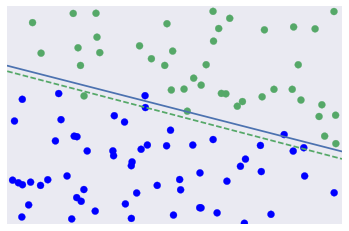

In [60]:
#====================== Line fitting ===============================
#======================= Model definition ==========================
N = 1 #degree of polynomial fitting

x = tf.placeholder(tf.float32, shape = (None, 2))
y_ = tf.placeholder(tf.float32, shape=(None, 2)) 
only_x = tf.slice(x, [0,0], [-1,1])
only_y = tf.slice(x, [0,1], [-1,1])
x_p = tf.pow(only_x, 0)
for i in range(N):
    power = tf.pow(only_x, i+1)
    x_p = tf.concat([x_p, power], 1)


W = tf.reshape(tf.Variable(tf.zeros([N+1,])), [N+1, 1])

p_x = tf.matmul(x_p, W)

y = 5*tf.nn.log_softmax(tf.concat([p_x, only_y], 1))
#===================== Quality_metrics =============================
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y)) 
#============================ Training =============================
train_step = tf.train.AdamOptimizer(0.001).minimize(cross_entropy)
#======================= Running session ===========================
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()

sess.run(init)

Train_loss = []
Test_loss = []
W_ = []

train_size = len(y_train)
test_size = len(y_test)
# validation_size = len(y_validation)

class Dataset(object):
    class Set_part(object):
        def __init__(self, data_type, set_type):
            self.set_type = set_type
            self.epoch = 0
            self.i = 0
            if set_type == 'train':
                self.size = train_size
#             elif set_type == 'validation':
#                 self.size = validation_size
            elif set_type == 'test':
                self.size = test_size
            else:
                raise Exception('set types: train, test')

            if data_type == 'usual':
                exec('self.data = X_%s'%set_type)
                exec('self.labels = y_%s'%set_type)

            else:
                raise Exception('data types: usual') 

            self.idx = np.arange(self.size)
            np.random.seed(42)
            np.random.shuffle(self.idx)

        def next_batch(self, batch_size):
            rng = self.idx[self.i * batch_size: (self.i + 1) * batch_size]
            batch = self.data.take(rng, 0)
            batch_labels = self.labels.take(rng, 0)
            self.i += 1
            if self.i >= self.size / batch_size:
                self.epoch += 1
                self.i = 0
                np.random.shuffle(self.idx)
            return batch, batch_labels

    def __init__(self, data_type = 'usual'):
        self.train = self.Set_part(data_type, 'train') 
#         self.validation = self.Set_part(data_type, 'validation')
        self.test = self.Set_part(data_type, 'test')

d = Dataset()

N_iter = 5000
pt = progress_timer(description= 'Polynomial madness', n_iter=N_iter)
for i in range(N_iter):
    batch = d.train.next_batch(128)
    sess.run(train_step, feed_dict={x: batch[0], y_: batch[1]})   
    Test_loss.append(sess.run(cross_entropy, feed_dict={x: X_test, y_: y_test}))
    Train_loss.append(sess.run(cross_entropy, feed_dict={x: batch[0], y_: batch[1]}))
    W_.append(sess.run(W))
    
    if i%50 == 0:
        plt.xticks([], [])
        plt.yticks([], [])
        drawing_classification(X_train, y_train, k, b, sess.run(W))
        plt.savefig('line/line_%s.pdf'%(str(int(i/50))))
        plt.clf()
    pt.update()
pt.finish()

plt.xticks([], [])
plt.yticks([], [])
drawing_classification(X_train, y_train, k, b, sess.run(W))
# plt.savefig('polynom.pdf')